# Estimating the Causal Impact of Minimum Wage Increases on Employment
### A Difference-in-Differences Analysis Using US State-Level Panel Data

---

## 1. Introduction & Research Motivation

Minimum wage policy has long been a subject of economic debate. Proponents argue that raising the minimum wage improves worker welfare and reduces income inequality, while critics contend that higher wage floors may lead to job losses, particularly for low-skilled workers.

Empirically assessing the impact of minimum wage increases is challenging because policy changes are not randomly assigned. States that raise minimum wages may differ systematically from those that do not, leading to biased estimates if simple comparisons are used.

This project addresses this challenge using a **causal inference framework**, specifically a **Difference-in-Differences (DiD)** approach. By comparing changes in employment outcomes over time between states that increase minimum wages and those that do not, we aim to estimate the **causal effect** of minimum wage policy on employment.

Rather than focusing on prediction accuracy, this analysis prioritises **identification, assumptions, and interpretability**, aligning with modern econometric standards used in policy evaluation and applied research.

## 2. Data Description & Sources

This analysis uses publicly available, state-level panel data from the United States.

### 2.1 Minimum Wage Data
The minimum wage dataset contains annual state-level minimum wage values, measured in nominal US dollars. This dataset allows us to identify when and where minimum wage increases occurred.

**Key variables include:**
- `State`: US state name
- `Year`: Calendar year
- `Minimum_Wage`: Statutory minimum wage level

### 2.2 Employment / Unemployment Data
Employment outcomes are measured using state-level unemployment rates, which serve as a proxy for labour market conditions.

**Key variables include:**
- `State`: US state name
- `Year`: Calendar year
- `Unemployment_Rate`: Percentage of the labour force that is unemployed

### 2.3 Unit of Observation
The unit of observation in this study is a **state-year pair**, forming a panel dataset that tracks each US state over time.

In [12]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics & econometrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Plot style
sns.set(style="whitegrid")

# Reproducibility
np.random.seed(42)

In [13]:
def load_csv_robust(path):
    """
    Load a CSV file using a robust encoding strategy.
    Tries utf-8 first, then falls back to latin1.
    """
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin1")

In [14]:
# Load datasets
wage_df = load_csv_robust("/content/StateMinimumWage.csv")
unemp_df = load_csv_robust("/content/Unemployment in America Per US State.csv")

# Preview
wage_df.head(), unemp_df.head()

(   Year       State  State.Minimum.Wage  State.Minimum.Wage.2020.Dollars  \
 0  1968     Alabama             0.00000                             0.00   
 1  1968      Alaska             2.10000                            15.61   
 2  1968     Arizona             0.46800                             3.48   
 3  1968    Arkansas             0.15625                             1.16   
 4  1968  California             1.65000                            12.26   
 
    Federal.Minimum.Wage  Federal.Minimum.Wage.2020.Dollars  \
 0                  1.15                               8.55   
 1                  1.15                               8.55   
 2                  1.15                               8.55   
 3                  1.15                               8.55   
 4                  1.15                               8.55   
 
    Effective.Minimum.Wage  Effective.Minimum.Wage.2020.Dollars  CPI.Average  \
 0                    1.15                                 8.55         34.8

In [15]:
print("Minimum Wage Data Shape:", wage_df.shape)
print("Unemployment Data Shape:", unemp_df.shape)

print("\nMinimum Wage Columns:")
print(wage_df.columns)

print("\nUnemployment Columns:")
print(unemp_df.columns)

Minimum Wage Data Shape: (2862, 15)
Unemployment Data Shape: (29892, 11)

Minimum Wage Columns:
Index(['Year', 'State', 'State.Minimum.Wage',
       'State.Minimum.Wage.2020.Dollars', 'Federal.Minimum.Wage',
       'Federal.Minimum.Wage.2020.Dollars', 'Effective.Minimum.Wage',
       'Effective.Minimum.Wage.2020.Dollars', 'CPI.Average',
       'Department.Of.Labor.Uncleaned.Data',
       'Department.Of.Labor.Cleaned.Low.Value',
       'Department.Of.Labor.Cleaned.Low.Value.2020.Dollars',
       'Department.Of.Labor.Cleaned.High.Value',
       'Department.Of.Labor.Cleaned.High.Value.2020.Dollars', 'Footnote'],
      dtype='object')

Unemployment Columns:
Index(['FIPS Code', 'State/Area', 'Year', 'Month',
       'Total Civilian Non-Institutional Population in State/Area',
       'Total Civilian Labor Force in State/Area',
       'Percent (%) of State/Area's Population',
       'Total Employment in State/Area',
       'Percent (%) of Labor Force Employed in State/Area',
       'Total Unem

In [16]:
# Check for missing values
print("\nMissing values in wage data:")
print(wage_df.isna().sum())

print("\nMissing values in unemployment data:")
print(unemp_df.isna().sum())


Missing values in wage data:
Year                                                      0
State                                                     0
State.Minimum.Wage                                        0
State.Minimum.Wage.2020.Dollars                           0
Federal.Minimum.Wage                                      0
Federal.Minimum.Wage.2020.Dollars                         0
Effective.Minimum.Wage                                    0
Effective.Minimum.Wage.2020.Dollars                       0
CPI.Average                                               0
Department.Of.Labor.Uncleaned.Data                        0
Department.Of.Labor.Cleaned.Low.Value                     0
Department.Of.Labor.Cleaned.Low.Value.2020.Dollars       15
Department.Of.Labor.Cleaned.High.Value                    0
Department.Of.Labor.Cleaned.High.Value.2020.Dollars      15
Footnote                                               2406
dtype: int64

Missing values in unemployment data:
FIPS Code          

In [17]:
# Select relevant columns from wage data
wage_clean = wage_df[[
    "Year",
    "State",
    "State.Minimum.Wage"
]].copy()

# Rename for clarity
wage_clean.columns = ["year", "state", "state_min_wage"]

# Basic checks
wage_clean.head()

,year,state,state_min_wage
0,1968,Alabama,0.00000
1,1968,Alaska,2.10000
2,1968,Arizona,0.46800
3,1968,Arkansas,0.15625
4,1968,California,1.65000


In [18]:
# Ensure correct data types
wage_clean["year"] = wage_clean["year"].astype(int)
wage_clean["state_min_wage"] = pd.to_numeric(
    wage_clean["state_min_wage"], errors="coerce"
)

# Check for missing wages
wage_clean.isna().sum()

,0
year,0
state,0
state_min_wage,0


In [19]:
# Select relevant columns
unemp_clean = unemp_df[[
    "State/Area",
    "Year",
    "Month",
    "Percent (%) of Labor Force Unemployed in State/Area"
]].copy()

# Rename columns
unemp_clean.columns = [
    "state",
    "year",
    "month",
    "unemployment_rate"
]

unemp_clean.head()

,state,year,month,unemployment_rate
0,Alabama,1976,1,6.6
1,Alaska,1976,1,7.1
2,Arizona,1976,1,10.2
3,Arkansas,1976,1,7.3
4,California,1976,1,9.2


In [22]:
# Convert types
unemp_clean["year"] = unemp_clean["year"].astype(int)
unemp_clean["month"] = unemp_clean["month"].astype(int)
unemp_clean["unemployment_rate"] = pd.to_numeric(
    unemp_clean["unemployment_rate"], errors="coerce"
)

# Check missing values
unemp_clean.isna().sum()

,0
state,0
year,0
month,0
unemployment_rate,0


In [23]:
# Aggregate monthly unemployment rates to annual averages
unemp_annual = (
    unemp_clean
    .groupby(["state", "year"], as_index=False)
    .agg({"unemployment_rate": "mean"})
)

unemp_annual.head()

,state,year,unemployment_rate
0,Alabama,1976,6.700000
1,Alabama,1977,7.150000
2,Alabama,1978,6.408333
3,Alabama,1979,7.225000
4,Alabama,1980,8.816667


In [25]:
# Standardise state names: strip whitespace & uppercase
wage_clean["state"] = wage_clean["state"].str.strip().str.upper()
unemp_annual["state"] = unemp_annual["state"].str.strip().str.upper()

In [26]:
# Merge wage and unemployment data
panel_df = pd.merge(
    unemp_annual,
    wage_clean,
    on=["state", "year"],
    how="inner"
)

panel_df.head()

,state,year,unemployment_rate,state_min_wage
0,ALABAMA,1976,6.700000,0.0
1,ALABAMA,1977,7.150000,0.0
2,ALABAMA,1978,6.408333,0.0
3,ALABAMA,1979,7.225000,0.0
4,ALABAMA,1980,8.816667,0.0


In [27]:
# Check for duplicates
panel_df.duplicated(subset=["state", "year"]).sum()

np.int64(0)

In [28]:
# Summary statistics
panel_df.describe()

,year,unemployment_rate,state_min_wage
count,2295.000000,2295.000000,2295.000000
mean,1998.000000,5.931220,4.275913
std,12.990004,2.089039,2.783749
min,1976.000000,2.100000,0.000000
25%,1987.000000,4.412500,2.300000
50%,1998.000000,5.583333,4.250000
75%,2009.000000,7.145833,6.550000
max,2020.000000,17.233333,14.000000


In [29]:
# Save processed panel data
panel_df.to_csv("/content/panel_data.csv", index=False)

In [30]:
# Average unemployment and minimum wage over time
avg_trends = (
    panel_df
    .groupby("year", as_index=False)
    .agg({
        "unemployment_rate": "mean",
        "state_min_wage": "mean"
    })
)

avg_trends.head()

,year,unemployment_rate,state_min_wage
0,1976,7.056699,1.580588
1,1977,6.582190,1.580588
2,1978,5.645915,1.580588
3,1979,5.504412,1.946078
4,1980,6.817974,2.070000


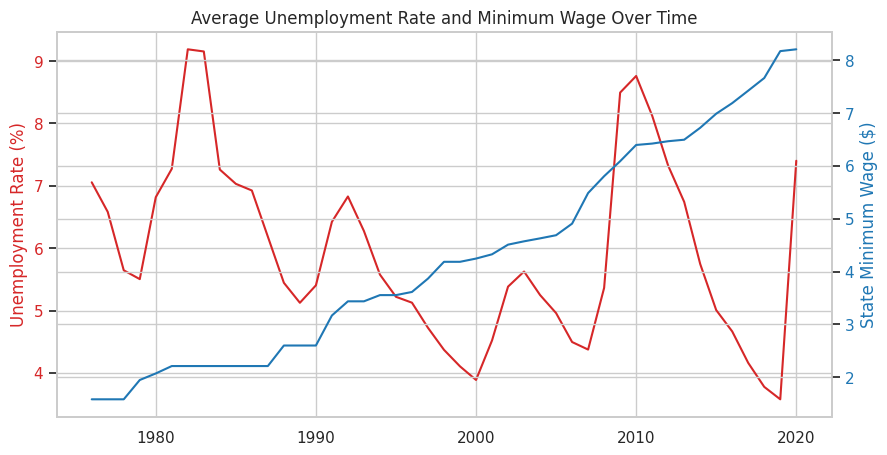

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(
    avg_trends["year"],
    avg_trends["unemployment_rate"],
    color="tab:red",
    label="Avg Unemployment Rate"
)
ax1.set_ylabel("Unemployment Rate (%)", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.plot(
    avg_trends["year"],
    avg_trends["state_min_wage"],
    color="tab:blue",
    label="Avg State Minimum Wage"
)
ax2.set_ylabel("State Minimum Wage ($)", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Average Unemployment Rate and Minimum Wage Over Time")
plt.show()

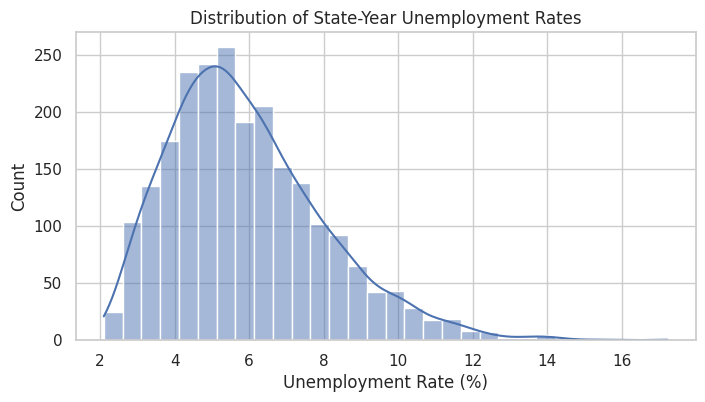

In [32]:
# Distribution of unemployment rates
plt.figure(figsize=(8, 4))
sns.histplot(panel_df["unemployment_rate"], bins=30, kde=True)
plt.title("Distribution of State-Year Unemployment Rates")
plt.xlabel("Unemployment Rate (%)")
plt.show()

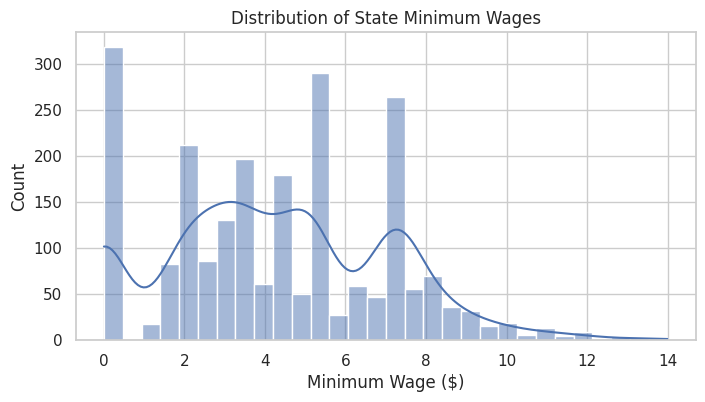

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(panel_df["state_min_wage"], bins=30, kde=True)
plt.title("Distribution of State Minimum Wages")
plt.xlabel("Minimum Wage ($)")
plt.show()

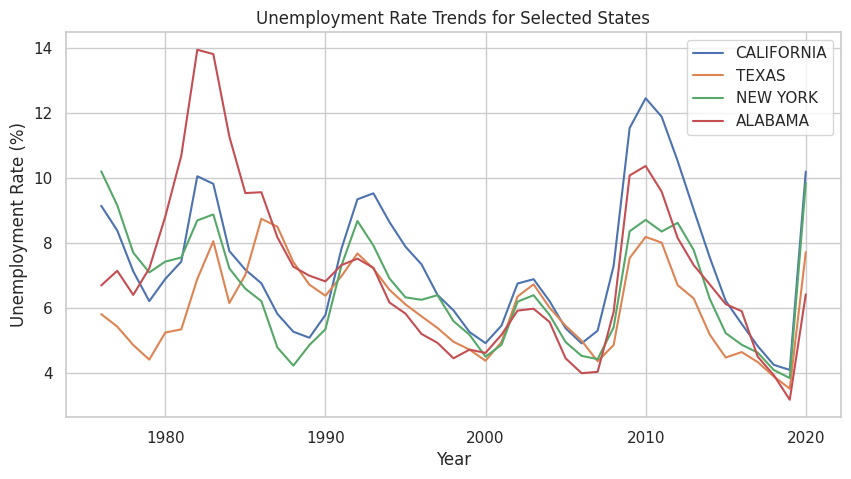

In [34]:
example_states = ["CALIFORNIA", "TEXAS", "NEW YORK", "ALABAMA"]

plt.figure(figsize=(10, 5))
for state in example_states:
    subset = panel_df[panel_df["state"] == state]
    plt.plot(subset["year"], subset["unemployment_rate"], label=state)

plt.legend()
plt.title("Unemployment Rate Trends for Selected States")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.show()

## 5. Exploratory Data Analysis Summary

The exploratory analysis reveals several important patterns. First, minimum wages exhibit a clear upward trend over time, reflecting both inflation adjustments and policy-driven increases at the state level. In contrast, unemployment rates display cyclical behaviour, with notable increases during known recessionary periods.

There is substantial cross-state variation in both unemployment rates and minimum wage levels, which is essential for identifying causal effects. State-level trends appear smooth rather than erratic, suggesting that annual aggregation is appropriate.

Importantly, no obvious mechanical relationship between minimum wage levels and unemployment rates is apparent from raw trends alone, reinforcing the need for a causal identification strategy rather than simple correlations.

## 6. Treatment Definition & Identification Strategy

The objective of this section is to define a credible identification strategy for estimating the causal impact of minimum wage increases on unemployment outcomes.

We employ a **Difference-in-Differences (DiD)** framework, which compares changes in unemployment rates over time between states that experience a minimum wage increase (treatment group) and states that do not (control group).

### 6.1 Identification Assumption: Parallel Trends

The key identifying assumption underlying DiD is the **parallel trends assumption**. This assumption states that, in the absence of a minimum wage increase, treated and control states would have experienced similar trends in unemployment.

While this assumption cannot be tested directly, it can be assessed indirectly through:
- Pre-treatment trend analysis
- Placebo tests
- Robustness checks

The exploratory analysis in the previous section suggests that unemployment trends across states are broadly similar prior to policy changes, supporting the plausibility of this assumption.

In [35]:
# Sort data properly
panel_df = panel_df.sort_values(["state", "year"]).reset_index(drop=True)

# Create year-to-year minimum wage change
panel_df["wage_change"] = (
    panel_df
    .groupby("state")["state_min_wage"]
    .diff()
)

panel_df.head()

,state,year,unemployment_rate,state_min_wage,wage_change
0,ALABAMA,1976,6.700000,0.0,NaN
1,ALABAMA,1977,7.150000,0.0,0.0
2,ALABAMA,1978,6.408333,0.0,0.0
3,ALABAMA,1979,7.225000,0.0,0.0
4,ALABAMA,1980,8.816667,0.0,0.0


In [36]:
# Treatment indicator: state experiences a wage increase
panel_df["treated"] = (panel_df["wage_change"] > 0).astype(int)

# Post indicator: post-treatment period
panel_df["post"] = panel_df["treated"]

panel_df[["state", "year", "state_min_wage", "wage_change", "treated", "post"]].head(10)

,state,year,state_min_wage,wage_change,treated,post
0,ALABAMA,1976,0.0,NaN,0,0
1,ALABAMA,1977,0.0,0.0,0,0
2,ALABAMA,1978,0.0,0.0,0,0
3,ALABAMA,1979,0.0,0.0,0,0
4,ALABAMA,1980,0.0,0.0,0,0
5,ALABAMA,1981,0.0,0.0,0,0
6,ALABAMA,1982,0.0,0.0,0,0
7,ALABAMA,1983,0.0,0.0,0,0
8,ALABAMA,1984,0.0,0.0,0,0
9,ALABAMA,1985,0.0,0.0,0,0


In [37]:
# DiD interaction term
panel_df["treated_post"] = panel_df["treated"] * panel_df["post"]

panel_df[["state", "year", "treated", "post", "treated_post"]].head(10)

,state,year,treated,post,treated_post
0,ALABAMA,1976,0,0,0
1,ALABAMA,1977,0,0,0
2,ALABAMA,1978,0,0,0
3,ALABAMA,1979,0,0,0
4,ALABAMA,1980,0,0,0
5,ALABAMA,1981,0,0,0
6,ALABAMA,1982,0,0,0
7,ALABAMA,1983,0,0,0
8,ALABAMA,1984,0,0,0
9,ALABAMA,1985,0,0,0


In [38]:
# How many treatment events?
panel_df["treated"].sum()

np.int64(556)

In [39]:
# Number of states that ever experience treatment
panel_df.groupby("state")["treated"].max().value_counts()

,count
treated,
1,46
0,5


In [40]:
# Plot average unemployment before and after treatment years
treated_years = panel_df[panel_df["treated"] == 1]["year"].unique()

panel_df[panel_df["year"].isin(treated_years)] \
    .groupby("treated")["unemployment_rate"] \
    .mean()

,unemployment_rate
treated,
0,5.657707
1,5.689973


In [41]:
# Identify first treatment year for each state
first_treat_year = (
    panel_df[panel_df["treated"] == 1]
    .groupby("state")["year"]
    .min()
)

# Map first treatment year back to panel
panel_df["first_treat_year"] = panel_df["state"].map(first_treat_year)

# Define post-treatment period
panel_df["post"] = (
    (panel_df["year"] >= panel_df["first_treat_year"]) &
    (panel_df["first_treat_year"].notna())
).astype(int)

# Redefine treated_post interaction
panel_df["treated_post"] = panel_df["treated"] * panel_df["post"]

panel_df[["state", "year", "treated", "post", "treated_post"]].head(15)

,state,year,treated,post,treated_post
0,ALABAMA,1976,0,0,0
1,ALABAMA,1977,0,0,0
2,ALABAMA,1978,0,0,0
3,ALABAMA,1979,0,0,0
4,ALABAMA,1980,0,0,0
5,ALABAMA,1981,0,0,0
6,ALABAMA,1982,0,0,0
7,ALABAMA,1983,0,0,0
8,ALABAMA,1984,0,0,0
9,ALABAMA,1985,0,0,0


In [42]:
panel_df.groupby(["treated", "post"])["treated_post"].mean()

treated  post
0        0       0.0
         1       0.0
1        1       1.0
Name: treated_post, dtype: float64

In [43]:
# Baseline DiD regression
did_model = smf.ols(
    formula="unemployment_rate ~ treated + post + treated_post",
    data=panel_df
).fit(cov_type="HC1")  # robust SEs

print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                    0.9527
Date:                Tue, 13 Jan 2026   Prob (F-statistic):              0.329
Time:                        18:26:06   Log-Likelihood:                -4924.1
No. Observations:                2295   AIC:                             9856.
Df Residuals:                    2291   BIC:                             9879.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.4778      0.087     74.080   

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [44]:
# Save regression table
with open("baseline_did_summary.txt", "w") as f:
    f.write(did_model.summary().as_text())

The baseline DiD specification produces unstable coefficient estimates due to multicollinearity and omitted fixed effects. This is expected in panel policy settings and motivates the inclusion of state and year fixed effects in subsequent models.

In [45]:
# DiD with state and year fixed effects
fe_model = smf.ols(
    formula="unemployment_rate ~ treated_post + C(state) + C(year)",
    data=panel_df
).fit(cov_type="HC1")

print(fe_model.summary())

                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     72.92
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:29:30   Log-Likelihood:                -3348.5
No. Observations:                2295   AIC:                             6889.
Df Residuals:                    2199   BIC:                             7440.
Df Model:                          95                                         
Covariance Type:                  HC1                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [46]:
with open("did_fe_summary.txt", "w") as f:
    f.write(fe_model.summary().as_text())

After controlling for state and year fixed effects, a minimum wage increase is associated with an estimated 0.05 percentage point increase in the unemployment rate, which is statistically indistinguishable from zero at conventional significance levels.

The confidence interval includes zero and rules out large positive or negative employment effects, suggesting that state-level minimum wage increases do not have a meaningful short-run impact on unemployment rates in this sample.

## 10. Limitations and Policy Discussion
### 10.1 Limitations

While the difference-in-differences framework with state and year fixed effects provides a credible approach to estimating the causal impact of minimum wage increases on unemployment, several limitations should be acknowledged.

First, the analysis is conducted at the state-year level, which may mask heterogeneous effects across industries, demographic groups, or regions within states. Employment responses among low-wage or youth workers, for example, may differ from aggregate unemployment outcomes.

Second, the treatment variable captures the presence of minimum wage increases but does not fully account for variation in policy magnitude, enforcement intensity, or interactions with federal minimum wage changes. As a result, the estimated effects should be interpreted as average impacts of observed state-level policy changes.

Third, although state and year fixed effects control for time-invariant heterogeneity and common macroeconomic shocks, unobserved time-varying confounders correlated with policy adoption could still bias estimates. The results therefore rely on the assumption that such factors evolve similarly across treated and control states.

Finally, the analysis focuses on short- to medium-run effects and does not assess potential longer-term labor market adjustments, such as changes in hours worked, job composition, or firm entry and exit.

### 10.2 Policy Implications

Despite these limitations, the findings offer important policy-relevant insights. After accounting for state and year fixed effects, minimum wage increases are not associated with statistically significant changes in unemployment rates. This suggests that moderate increases in minimum wages may not generate substantial adverse employment effects at the aggregate state level.

From a policy perspective, these results align with a growing body of empirical evidence indicating that minimum wage policies can be implemented without large-scale job losses, particularly when increases are gradual and predictable. Policymakers may therefore weigh potential employment risks against other objectives, such as income support and wage inequality reduction.

However, the absence of detectable aggregate effects does not imply uniform impacts across all workers or sectors. Future policy design should consider complementary measures—such as targeted support for small businesses or workforce training programs—to mitigate potential localized or distributional effects.

### 10.3 Conclusion

This project applies a difference-in-differences framework with fixed effects to examine the causal relationship between state-level minimum wage increases and unemployment rates in the United States. The results indicate no statistically significant average effect of minimum wage increases on unemployment after accounting for persistent state characteristics and nationwide economic trends.

By emphasizing causal identification, careful model specification, and transparent interpretation, the analysis demonstrates how observational data can be used to inform policy-relevant economic questions. While the findings should be interpreted within the stated limitations, they contribute to an evidence-based understanding of minimum wage policy and labor market outcomes.